
# Table of Contents:

* **1. [Introduction](#Introduction)** <br>
* **2. [Importing libraries](#Importing_libraries)** <br>
* **3. [NetCDF file content and visualization](#NetCDF_file_content)** <br>
* **4. [Visualisation of NO2 during April 2019 & 2020](#Lockdown)** <br>





# **1. Introduction** <a id="Introduction"></a> <br> 

The notebook aims at explaining how to use Sentinel5P data for air quality (NO2 and Aerosols).  The <a href="https://atmospherictoolbox.org/"> Atmospheric Toolbox </a> and the <a href="http://xarray.pydata.org/en/stable/"> xarray </a> Python library will be used throughout the notebook. 

By the end of the notebook you will have learned how to use Sentinel 5P data and make nice plots to monitor air quality. In particular, we will see how the lockdown during April 2020 affected air quality by comparing the data during the same period during the 2019.

<a id="Importing_libraries"></a> <br> 
# **2. Importing libraries** 

In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt # Visualization
import cartopy.crs as ccrs # Projected visualizations
import xarray as xr # Open, read and Process netCDF files
import numpy as np # Data manupulation
import cartopy # improved visualizations
from glob import glob # data access in file manager
import os
from os.path import join # data access in file manager
import pandas as pd # data manipulation
import harp #Python interface of the atmospheric toolbox to open read and process Sentinel-5P products
import imageio # create gif 

<a id="NetCDF_file_content"></a> <br> 
# **3. NetCDF file content** 

Data have been downloaded offline by the <a href="https://s5phub.copernicus.eu/dhus/"> Copernicus scihub </a>.

Data can be downloaded also via batch scripting. For further information go <a href="https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/BatchScripting?redirectedfrom=SciHubUserGuide.8BatchScripting"> to </a>

In [2]:
# Define your data local directory path and your filename file
cwd = os.getcwd()
files = glob(os.path.join(cwd,"Data\\NO2\\*.nc"))
#file = os.path.join(cwd,"Data\\NO2\\")#S5P_OFFL_L2__NO2____20190323T214328_20190323T232458_07470_01_010300_20190329T2304054.nc')

In [3]:
files

['C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2\\S5P_OFFL_L2__NO2____20200401T110350_20200401T124521_12784_01_010302_20200403T040102.nc']

In [4]:
file = files[0]

In [5]:
# Open product and read global attributes
fileRead = xr.open_dataset(file,'PRODUCT')  

In [6]:
###  Print the coordinates of a netCDF file ###
fileRead.coords

Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2020-04-01
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * polynomial_exponents                   (polynomial_exponents) float64 0.0...
  * intensity_offset_polynomial_exponents  (intensity_offset_polynomial_exponents) float64 ...
  * layer                                  (layer) float64 0.0 1.0 ... 32.0 33.0
  * vertices                               (vertices) float64 0.0 1.0
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...

In [7]:
# Print the different variables of the netCDF file 
fileRead.data_vars

Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column                   (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) f

In [8]:
# Read the time variable
Time=fileRead.time.values
Time

array(['2020-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
### Time variable ###
date=Time.astype('datetime64[D]') #astype allows to choose the precision of the date: D for Day, Y for years, M for months, h for hours etc

### Store the longitude and latitude in arrays
longitude=fileRead['longitude'] # get longitude
latitude=fileRead['latitude']   # get latitude
###  Store the variable NO2
NO2=fileRead['nitrogendioxide_tropospheric_column'] #store the NO2 measurement variable of FIn in VarNO2

fileRead.close() #Close the xarray Dataset 

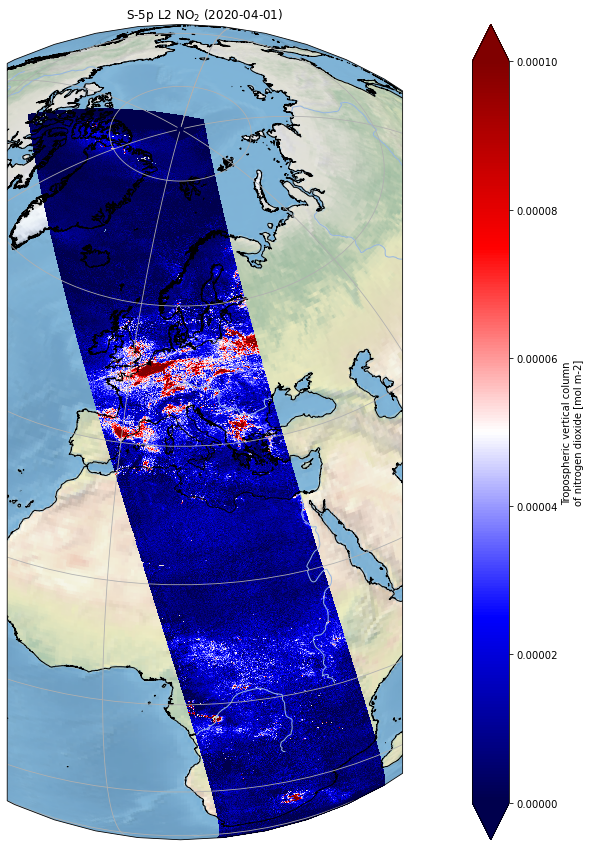

In [10]:
# Visualization using Cartopy and Orthographic projection
fig=plt.figure(figsize=(25,15))                    # create a figure 
ax = plt.axes(projection=ccrs.Orthographic(11,42)) # Creates an empty subplot and chose Orthographic projection

# Plot NO2 
NO2[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude', \
                          add_colorbar=True, cmap='seismic', \
                          vmin=0,vmax=0.0001,transform=ccrs.PlateCarree()) 

ax.add_feature(cartopy.feature.RIVERS)                    # add river
ax.set_title('S-5p L2 NO$_2$ ({}) '.format(str(date[0]))) # add title
ax.coastlines('10m')                                      # add coastline
ax.stock_img()                                            # add the color of earth
ax.gridlines()                                            # add grid line



# Save figure to file
plt.savefig(os.path.join(cwd,"Output/NO2plot.png"), bbox_inches='tight', dpi=300)

<a id="Lockdown"></a> <br> 
# **4. Visualisation of NO2 during April 2019 & 2020** 


To visualise data during Avril 2019 and Avril 2020, we need to average data for this two periods. We will take n files in input and we will generate 1 output file with the average quantities. This process should be repeated for both 2019 and 2020 data.


First method: harpemerge command

In [11]:
# If you are using Jupyter on Linux we can just uncomment and run the following command
# Note. you shall change the input/output folders

#!harpmerge -ap 'bin(); squash(time, (latitude,longitude))' \
#-a 'latitude >= 40 [degree_north]; latitude <=60  [degree_north]; \
#longitude>=-22 [degree_east];longitude<=26 [degree_east]; \
#tropospheric_NO2_column_number_density_validity>75; \
#bin_spatial(360,40,0.05,960,-22,0.05); \
#derive(longitude {longitude});derive(latitude {latitude}); \
#keep(latitude,longitude,tropospheric_NO2_column_number_density,weight)' \
#/mnt/c/Users/degas/Documenti/Github/Sentinel5P/Data/NO2_2019/Input/S5P_OFFL_L2__NO2____20190*.nc \
#/mnt/c/Users/degas/Documenti/Github/Sentinel5P/Data/NO2_2019/Output/converted_NO2_2019_final.nc

In [12]:
# If you are using Jupyter on Windows you can run this command from windows command line or on the windows subsystem for linux
# Note. you shall change the input/output folders. If using the windows sub for Linux use "/" for the path otherwise use "\\"
# harpmerge -ap 'bin(); squash(time, (latitude,longitude))' -a 'latitude >= 40 [degree_north]; latitude <=60  [degree_north]; longitude>=-22 [degree_east];longitude<=26 [degree_east]; tropospheric_NO2_column_number_density_validity>75; bin_spatial(360,40,0.05,960,-22,0.05); derive(longitude {longitude});derive(latitude {latitude}); keep(latitude,longitude,tropospheric_NO2_column_number_density,weight)' /mnt/c/Users/degas/Documenti/Github/Sentinel5P/Data/NO2_2019/Input/S5P_OFFL_L2__NO2____20190*.nc /mnt/c/Users/degas/Documenti/Github/Sentinel5P/Data/NO2_2019/Output/converted_NO2_2019_final.nc

Second method: harp python interface

In [13]:
# Specify input and output of harp.import_product
input_files='C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2019\\Input\\S5P*.nc' 
export_path='C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2019\\Output\\converted_NO2_2019_final.nc' 

In [14]:
#Use harp.import_product python function to generate 
Converted_NO2_2019 = harp.import_product(input_files, \
                      operations= "latitude >= 40[degree_north] ; latitude <= 60 [degree_north] ; \
                      longitude>=-22 [degree_east];longitude<=26 [degree_east];tropospheric_NO2_column_number_density_validity>75; \
                      bin_spatial(360, 40, 0.05, 960, -22, 0.05); \
                      derive(latitude {latitude}); derive(longitude {longitude}); \
                      keep(latitude,longitude,tropospheric_NO2_column_number_density,weight)", \
                      post_operations="bin(); squash(time, (latitude,longitude))"                   
                      )
        
harp.export_product(Converted_NO2_2019, export_path,file_format="netcdf")

In [15]:
# Specify input and output of harp.import_product
input_files='C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2020\\Input\\S5P*.nc' 
export_path='C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2020\\Output\\converted_NO2_2020_final.nc' 

In [16]:
#Use harp.import_product python function to generate 
Converted_NO2_2020 = harp.import_product(input_files, \
                      operations= "latitude >= 40[degree_north] ; latitude <= 60 [degree_north] ; \
                      longitude>=-22 [degree_east];longitude<=26 [degree_east];tropospheric_NO2_column_number_density_validity>75; \
                      bin_spatial(360, 40, 0.05, 960, -22, 0.05); \
                      derive(latitude {latitude}); derive(longitude {longitude}); \
                      keep(latitude,longitude,tropospheric_NO2_column_number_density,weight)", \
                      post_operations="bin(); squash(time, (latitude,longitude))"                   
                      )
        
harp.export_product(Converted_NO2_2020, export_path,file_format="netcdf")

Once we have obtained the average for the 2019 and 2020, we can plot the NO2 emissions for these periods and see the differences

In [17]:
# Directory where the data is stored
average_2019=r'C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2019\\Output\\converted_NO2_2019_final.nc'
average_2020=r'C:\\Users\\degas\\Documents\\Github\\Sentinel5P\\Data\\NO2_2020\\Output\\converted_NO2_2020_final.nc'

# Put the data in the Datasets
input2019 = xr.open_dataset(average_2019)
input2020 = xr.open_dataset(average_2020)

# Save tropospheric NO2 data
# Mutiply by 1000 to convert from [mol.m-2] to [mmol.m-2] 
NO22019=input2019['tropospheric_NO2_column_number_density']*(10**3)
NO22020=input2020['tropospheric_NO2_column_number_density']*(10**3)

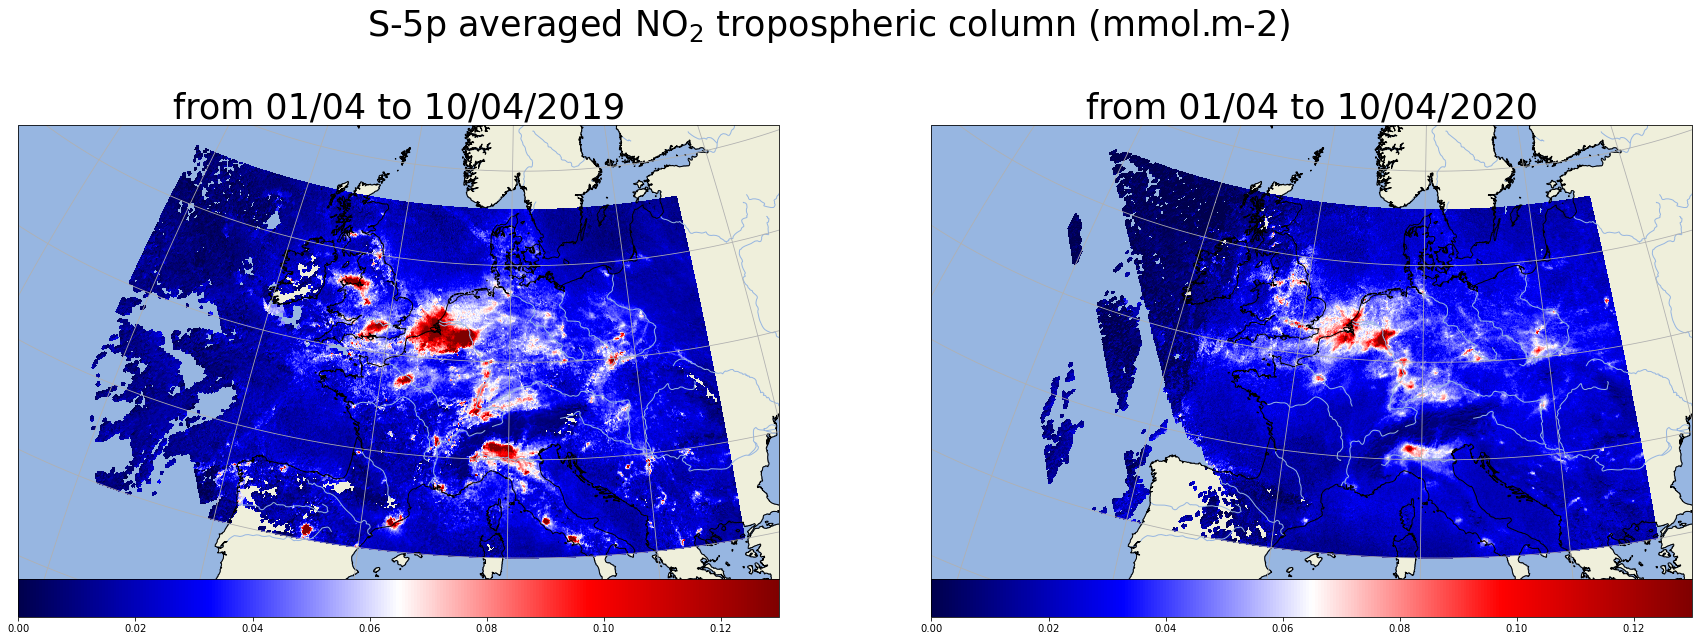

In [18]:
fig,(axe1,axe2)=plt.subplots(1,2,figsize=(30,10)) #1 row, 2 columns

# First figure
axe1 = plt.subplot(121, projection=ccrs.Orthographic(11,42)) #121 means 1 line, 2 columns, 1st subplot from the left
im1=NO22019[0].plot.pcolormesh(ax=axe1, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)

axe1.set_title('from 01/04 to 10/04/2019',fontsize=35)
axe1.add_feature(cartopy.feature.LAND, edgecolor='black')
axe1.add_feature(cartopy.feature.OCEAN)
axe1.add_feature(cartopy.feature.RIVERS)
axe1.coastlines('10m')
axe1.gridlines()
plt.colorbar(im1, orientation="horizontal",pad=0) #pad adjust the space between plots and colorbar
# Second figure
axe2 = plt.subplot(122, projection=ccrs.Orthographic(11, 42)) #122 means 1 line, 2 columns, 2nd subplot from the left
im2=NO22020[0].plot.pcolormesh(ax=axe2, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)

axe2.set_title('from 01/04 to 10/04/2020',fontsize=35)
axe2.add_feature(cartopy.feature.LAND, edgecolor='black')
axe2.add_feature(cartopy.feature.OCEAN)
axe2.add_feature(cartopy.feature.RIVERS)
axe2.coastlines('10m')
axe2.gridlines()
plt.colorbar(im2, orientation="horizontal",pad=0) #pad adjust the space between plots and colorbar

fig.suptitle('S-5p averaged NO$_2$ tropospheric column (mmol.m-2)',fontsize=35,va='bottom')
# Save figure to file
plt.savefig(os.path.join(cwd,"Output/NO2_2019&2020_horizontal.png"), bbox_inches='tight', dpi=300)



We see that emissions of NO2 emissions were reduced in 2020 with respect to 2019 in the 2 most industrial zones of Europe:
the Po valley in Italy and the north of Europe (Belgium, Germany and Holland). We can also do other plots to better see these differences.

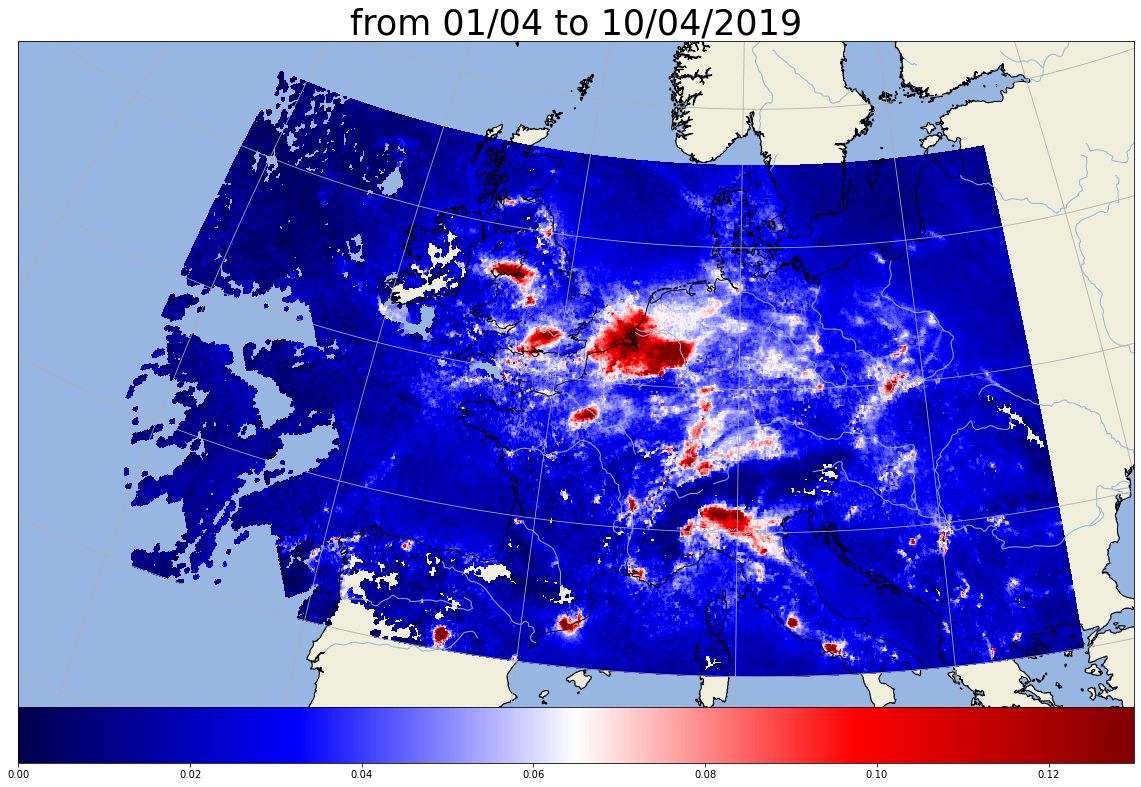

In [19]:
# Visualization using Cartopy and Orthographic projection
fig=plt.figure(figsize=(20,20)) # create a figure frame and set up the figure size
ax = plt.axes(projection=ccrs.Orthographic(11,42)) # Creates an empty subplot with Orthographic projection

# Plot VarNO2 where we remove the time dimension `VarNO2[0]`
im1=NO22019[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)


ax.set_title('from 01/04 to 10/04/2019',fontsize=35)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines('10m')
ax.gridlines()
plt.colorbar(im1, orientation="horizontal",pad=0) #pad adjust the space between plots and colorbar


plt.savefig(os.path.join(cwd,"Output/NO2_2019_horizontal.png"), bbox_inches='tight', dpi=300)

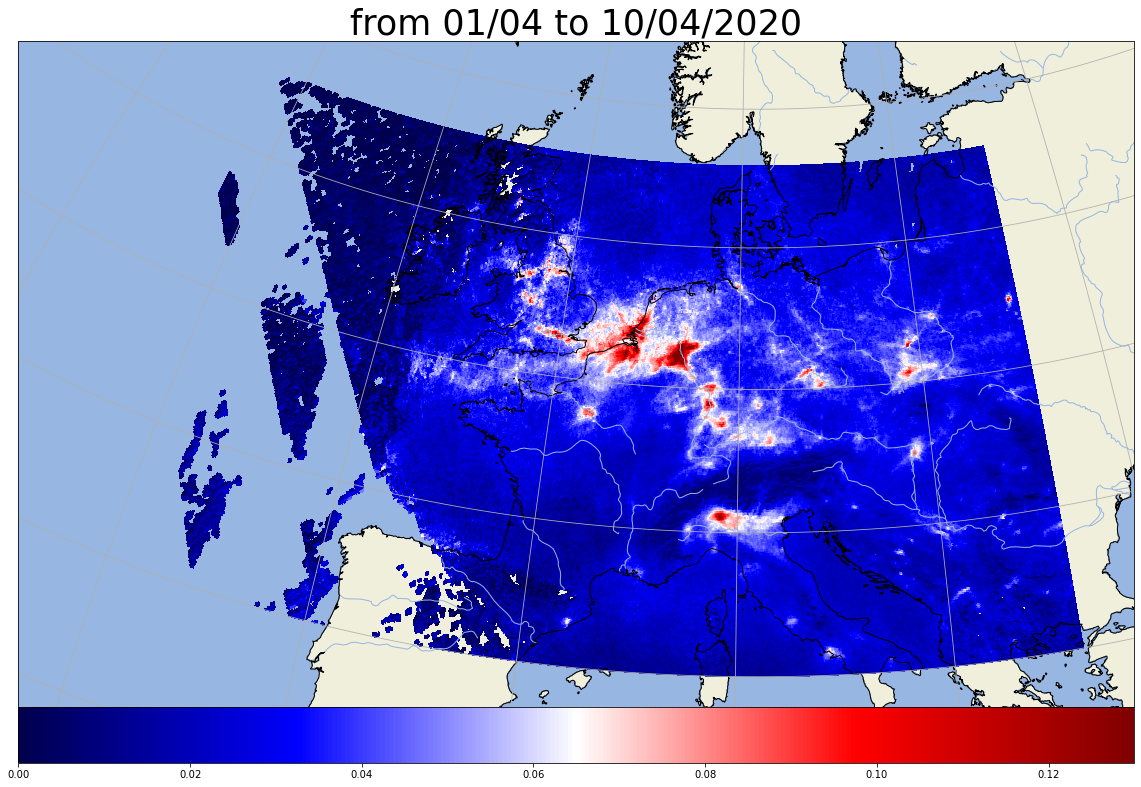

In [20]:
# Visualization using Cartopy and Orthographic projection
fig=plt.figure(figsize=(20,20)) # create a figure frame and set up the figure size
ax = plt.axes(projection=ccrs.Orthographic(11,42)) # Creates an empty subplot with Orthographic projection

# Plot VarNO2 where we remove the time dimension `VarNO2[0]`
im1=NO22020[0].plot.pcolormesh(ax=ax, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)


ax.set_title('from 01/04 to 10/04/2020',fontsize=35)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.RIVERS)
ax.coastlines('10m')
ax.gridlines()
plt.colorbar(im1, orientation="horizontal",pad=0) #pad adjust the space between plots and colorbar


plt.savefig(os.path.join(cwd,"Output/NO2_2020_horizontal.png"), bbox_inches='tight', dpi=300)

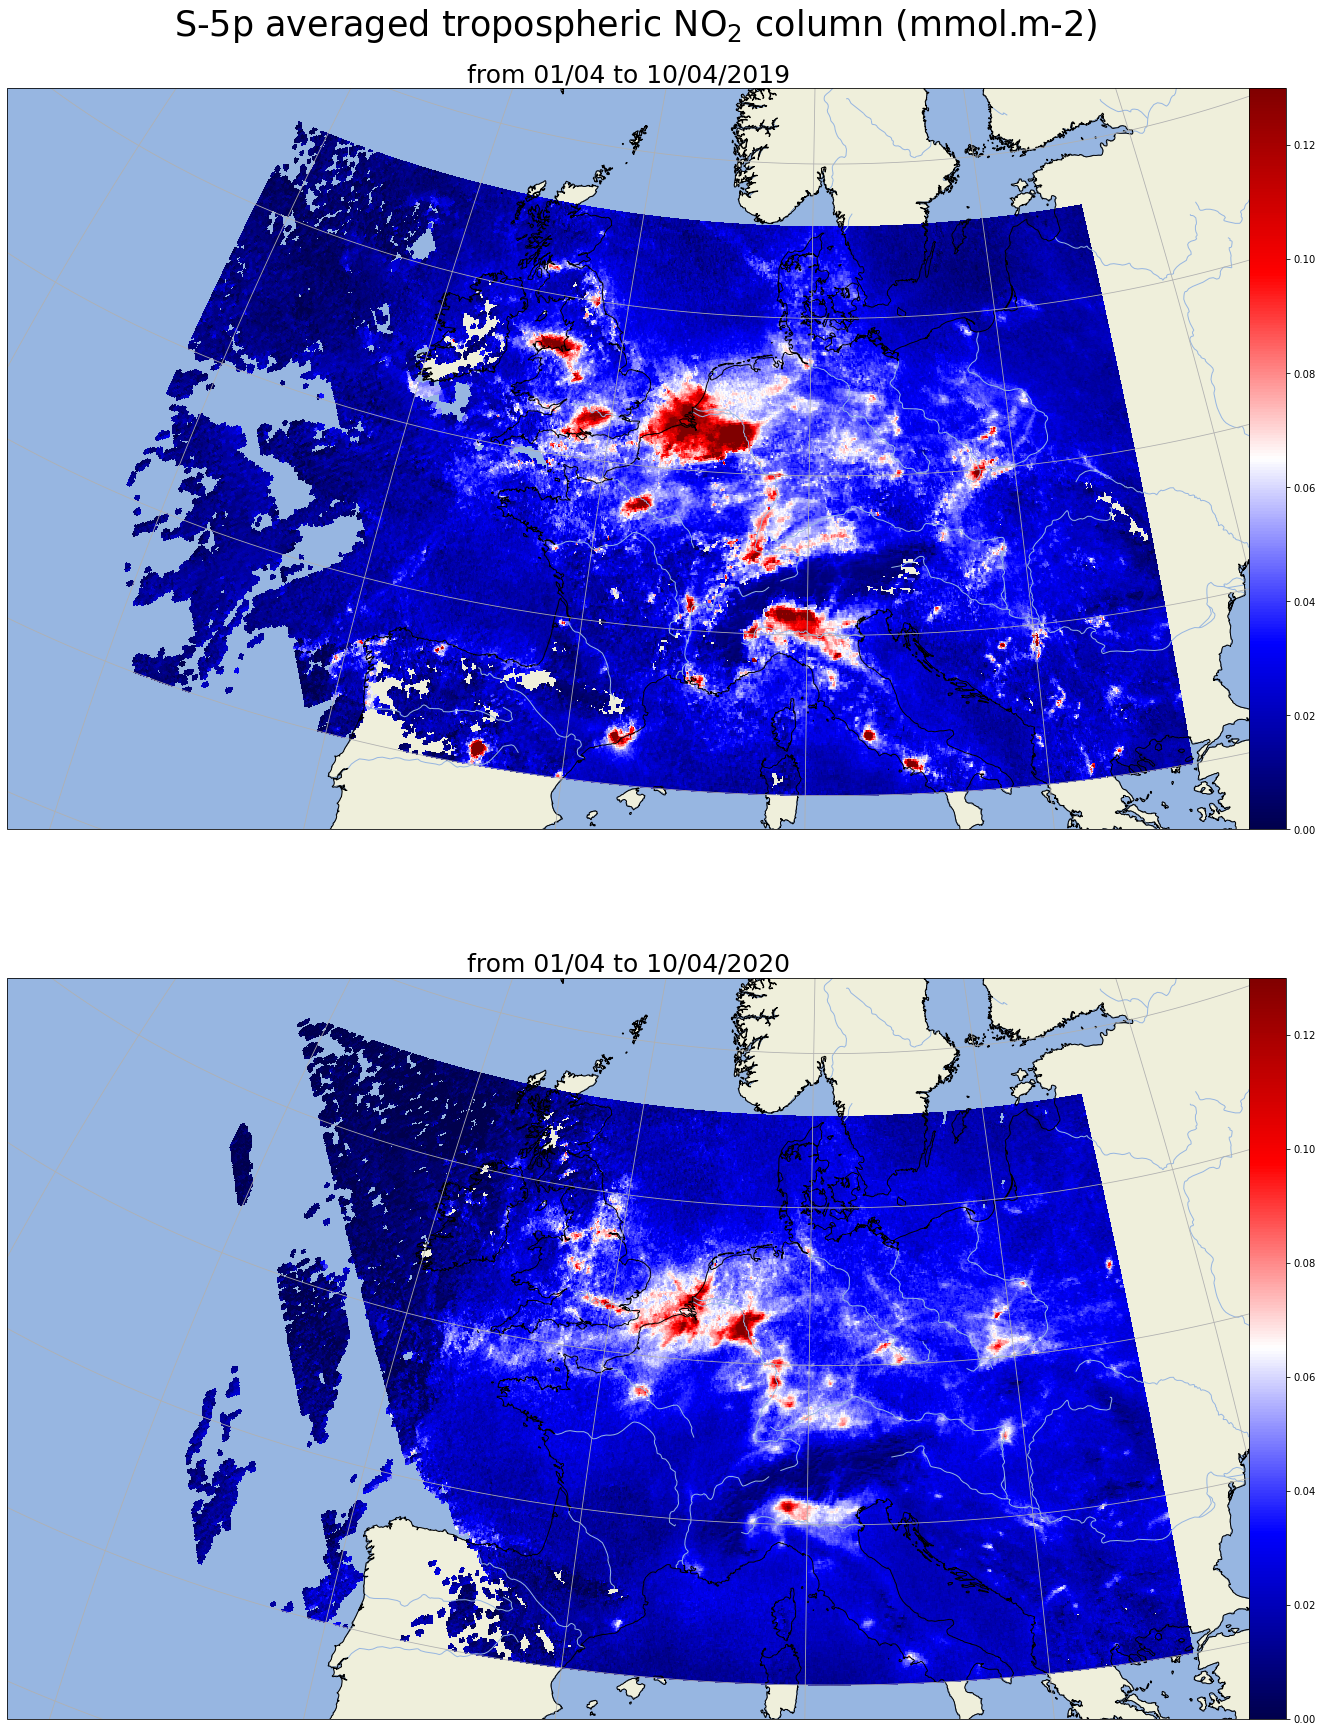

In [21]:
fig,(axe1,axe2)=plt.subplots(2,1,figsize=(30,30)) #1 row, 2 columns

# First figure
axe1 = plt.subplot(211, projection=ccrs.Orthographic(11,42))
im1=NO22019[0].plot.pcolormesh(ax=axe1, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)

axe1.set_title('from 01/04 to 10/04/2019',fontsize=25)
axe1.add_feature(cartopy.feature.LAND, edgecolor='black')
axe1.add_feature(cartopy.feature.OCEAN)
axe1.add_feature(cartopy.feature.RIVERS)
axe1.coastlines('10m')
axe1.gridlines()
plt.colorbar(im2,shrink=1,pad=0)

# Second figure
axe2 = plt.subplot(212, projection=ccrs.Orthographic(11, 42))
im2=NO22020[0].plot.pcolormesh(ax=axe2, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=0, vmax=0.13)

axe2.set_title('from 01/04 to 10/04/2020',fontsize=25)
axe2.add_feature(cartopy.feature.LAND, edgecolor='black')
axe2.add_feature(cartopy.feature.OCEAN)
axe2.add_feature(cartopy.feature.RIVERS)
axe2.coastlines('10m')
axe2.gridlines()
plt.colorbar(im2,shrink=1,pad=0)

fig.suptitle('S-5p averaged tropospheric NO$_2$ column (mmol.m-2)',y=0.9,fontsize=35,va='bottom')
# Save figure to file
plt.savefig(os.path.join(cwd,"Output/NO2_2019&2020_vertical.png"), bbox_inches='tight', dpi=300)


## Anomaly map

We can obtain some insights by plotting an anomaly map (2020 emissions - 2019 emissions)

In [22]:
#First create Anomaly Dataset to store the 2019 tropospheric_NO2_column_number_density DataArray
Anomaly=input2019[['tropospheric_NO2_column_number_density']].rename({'tropospheric_NO2_column_number_density' : 'tropospheric_NO2_column_number_density_2019'})

#Add the 2020 tropospheric_NO2_column_number_density DataArray to Anomaly DataSet
Anomaly['tropospheric_NO2_column_number_density_2020']=(('time','latitude','longitude'),input2020['tropospheric_NO2_column_number_density'])

In [23]:
# We define the difference between 2020 and 2019 in the DataSet Anomaly:
Anomaly['diff_2020_2019']=(Anomaly['tropospheric_NO2_column_number_density_2020']-Anomaly['tropospheric_NO2_column_number_density_2019'])*1000

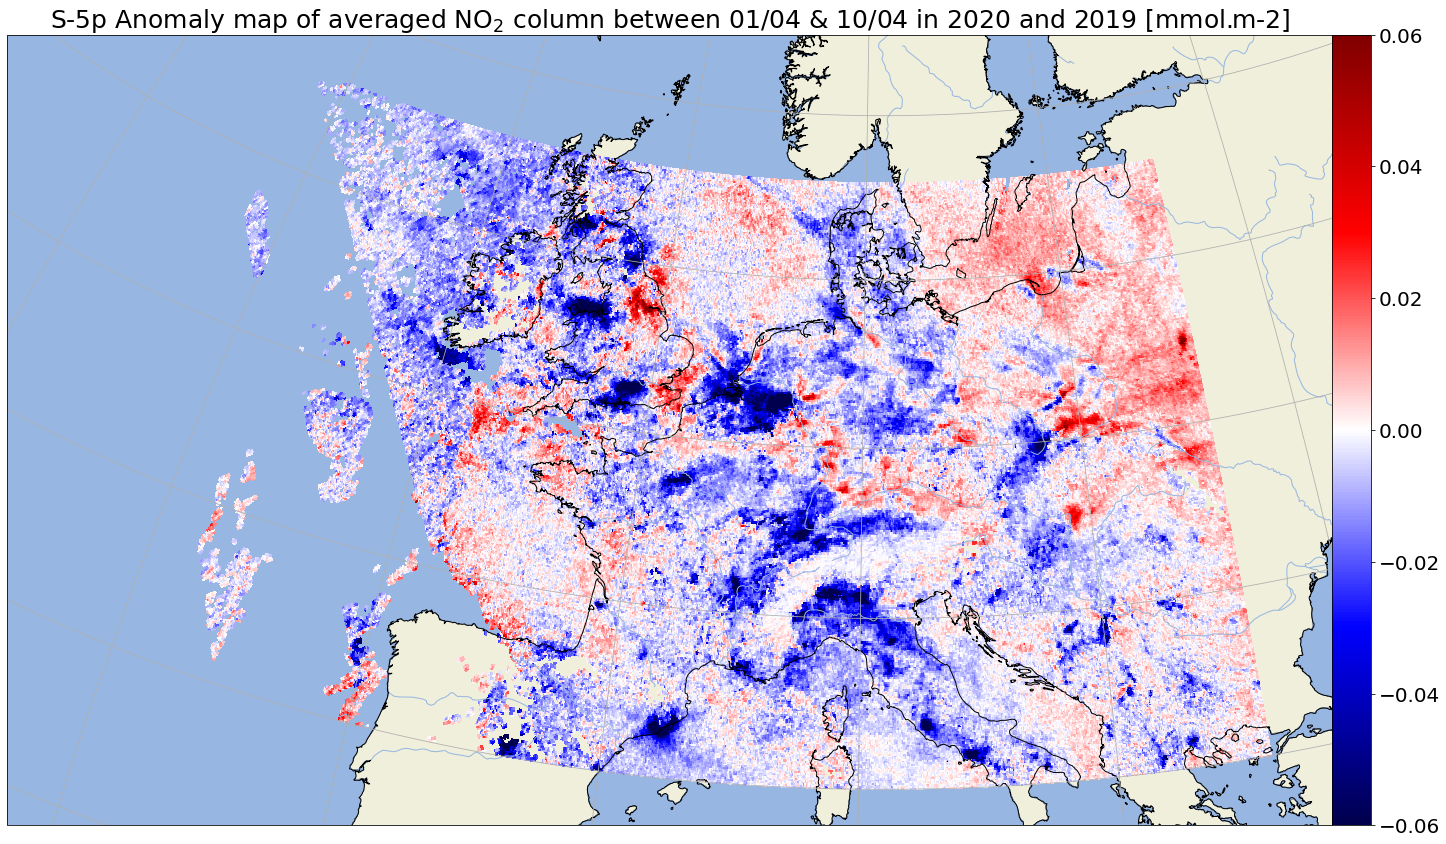

In [24]:
# Plot the anomaly map
fig= plt.figure(figsize=(64,32))
axe1 = plt.subplot(211, projection=ccrs.Orthographic(11,42))
P=Anomaly['diff_2020_2019'][0].plot.pcolormesh(ax=axe1, x='longitude', y='latitude',add_colorbar=False, cmap='seismic', transform=ccrs.PlateCarree(), vmin=-0.06, vmax=0.06)

#fig.colorbar(P,fontsize=25)
plt.colorbar(P,pad=0).ax.tick_params(labelsize=20)

axe1.set_title('S-5p Anomaly map of averaged NO$_2$ column between 01/04 & 10/04 in 2020 and 2019 [mmol.m-2]',fontsize=25)
axe1.add_feature(cartopy.feature.LAND, edgecolor='black')
axe1.add_feature(cartopy.feature.OCEAN)
axe1.add_feature(cartopy.feature.RIVERS)
axe1.coastlines('10m')
axe1.gridlines()

# Save figure to file
plt.savefig("Output/NO2_anomaly_map_2019&2020.png", bbox_inches='tight', dpi=300)

Negative values means that there were less emissions in 2020 than 2019. We can note that this is the case for the 2 mentioned industrail region: the Po Valley in Italy and the industrial area between Belgium, Germany and Holland